Quantum Circuit:
      ┌───┐                                                   ┌───┐  ░      »
 q_0: ┤ H ├──■────■────■─────────■────────────────────────────┤ X ├──░───■──»
      └───┘┌─┴─┐  │    │         │                     ┌───┐  └─╥─┘  ░ ┌─┴─┐»
 q_1: ─────┤ X ├──┼────┼────■────┼─────────────────────┤ X ├────╫────░─┤ X ├»
           └───┘┌─┴─┐  │    │    │              ┌───┐  └─╥─┘    ║    ░ └───┘»
 q_2: ──────────┤ X ├──┼────┼────┼────■─────────┤ X ├────╫──────╫────░──────»
                └───┘┌─┴─┐┌─┴─┐  │    │  ┌─┐    └─╥─┘    ║      ║    ░      »
 q_3: ───────────────┤ X ├┤ X ├──┼────┼──┤M├──────╫──────╫──────╫───────────»
                     └───┘└───┘┌─┴─┐┌─┴─┐└╥┘┌─┐   ║      ║      ║           »
 q_4: ─────────────────────────┤ X ├┤ X ├─╫─┤M├───╫──────╫──────╫───────────»
                               └───┘└───┘ ║ └╥┘┌──╨──┐┌──╨──┐┌──╨──┐        »
c0: 2/════════════════════════════════════╩══╩═╡ 0x1 ╞╡ 0x2 ╞╡ 0x3 ╞════════»
                                          0  1 

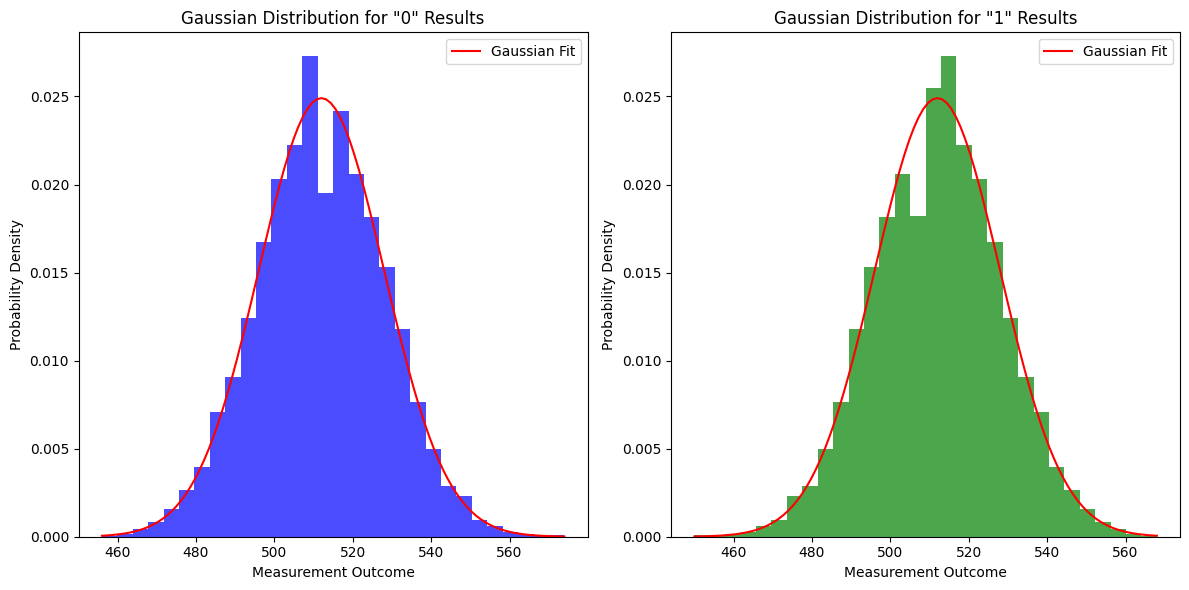

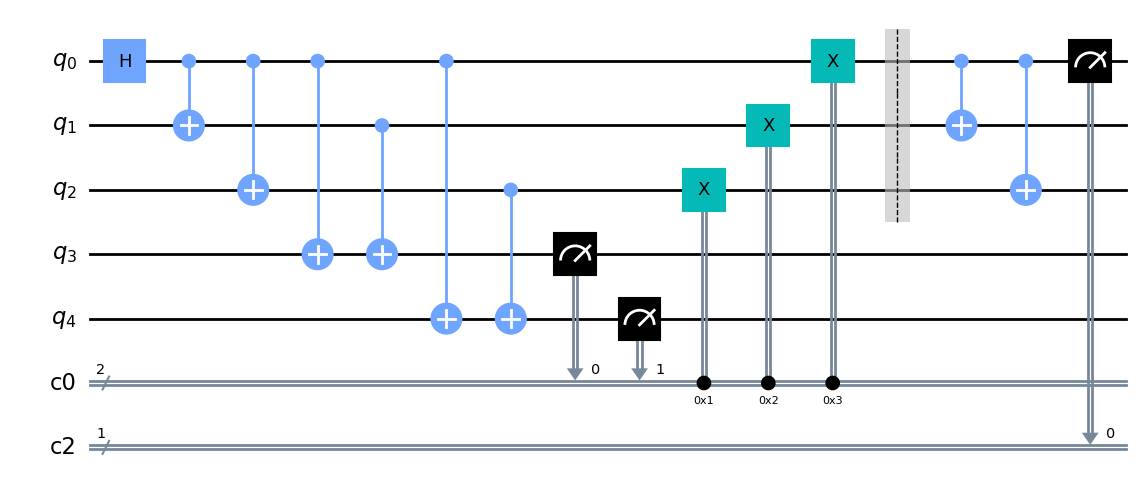

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, assemble, Aer, execute
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import AerSimulator

# Number of times to repeat the circuit
n = 10000

q = QuantumRegister(5, 'q')
c0 = ClassicalRegister(2, 'c0')
c2 = ClassicalRegister(1, 'c2')

# Define the circuit
bit_flip = QuantumCircuit(q, c0,c2)

# Prepares qubit in the desired initial state 
bit_flip.h(q[0])

# Encodes the qubit in a three-qubit entangled state  
bit_flip.cx(q[0], q[1])
bit_flip.cx(q[0], q[2])

# Adds additional two qubits for error-correction
bit_flip.cx(q[0], q[3])
bit_flip.cx(q[1], q[3])
bit_flip.cx(q[0], q[4])
bit_flip.cx(q[2], q[4])

# Measure the two additional qubits
bit_flip.measure(q[3], c0[0])
bit_flip.measure(q[4], c0[1])

# Do error correction
bit_flip.x(q[2]).c_if(c0, 1)
bit_flip.x(q[1]).c_if(c0, 2)
bit_flip.x(q[0]).c_if(c0,3)

# I add a barrier to separate the operations
bit_flip.barrier(q[0],q[1],q[2])

# Decodes the qubit from the three-qubit entangled state  
bit_flip.cx(q[0], q[1])
bit_flip.cx(q[0], q[2])

# Check the state of the initial qubit
bit_flip.measure(q[0], c2[0])

# Print the quantum circuit
print("Quantum Circuit:")
print(bit_flip)

# Draw the circuit using Matplotlib and save it as a PNG file
bit_flip.draw(output='mpl', filename='h_corr.png')

# Simulate the circuit using the Aer simulator
simulator = AerSimulator(method='statevector')

# Lists to store the '0' and '1' measurement outcomes (it's necessary to be able to calculate
results_0 = []
results_1 = []

# Create a file to write measurements
with open('measurements_0_h.txt', 'w') as file0, open('measurements_1_h.txt', 'w') as file1:
    for i in range(n):
        # Compile the circuit
        compiled_circuit = transpile(bit_flip, simulator)

        # Run the circuit
        job = simulator.run(compiled_circuit)

        # Get the result
        result = job.result()

        # Get the counts for '00' and '11' outcomes
        counts = result.get_counts()
        count_0 = counts.get('0 00', 0)
        count_1 = counts.get('1 00', 0)
    
        # Write the measurement outcomes to the file in columns
        file0.write(f"{count_0}")
        
        # Return for readability
        file0.write("\n")

        # Write the measurement outcomes to the file in columns
        file1.write(f"{count_1}")
        
        # Return for readability
        file1.write("\n")
        
        # Append the outcomes to the lists
        results_0.append(count_0)
        results_1.append(count_1)
        
# Calculate the standard deviation for '0' and '1' outcomes
std_deviation_0 = np.std(results_0, ddof = 0)
std_deviation_1 = np.std(results_1, ddof = 0)

# Get the mean value for '0' and '1':
mean_0 = np.mean(results_0)
mean_1 = np.mean(results_1)

# Print the standard deviations
print(f"Standard Deviation of '0' Results: {std_deviation_0:.4f}")
print(f"Standard Deviation of '1' Results: {std_deviation_1:.4f}")

# Print mean
print(f"Mean of '0' Results: {mean_0:.4f}")
print(f"Mean of '1' Results: {mean_1:.4f}")

print("Measurement outcomes have been saved to 'measurements_0_h.txt' and 'measurements_1_h.txt' with columns for '0' and '1' results.")
print("The circuit has been saved as 'h_corr.png'.")

## PLot the results into a Gaussian distribution

# Plot the '00' and '11' measurement results as Gaussian distributions
plt.figure(figsize=(12, 6))

# Plot '00' results
plt.subplot(1, 2, 1)
plt.hist(results_0, bins=30, density=True, color='blue', alpha=0.7)
plt.title('Gaussian Distribution for "0" Results')
plt.xlabel('Measurement Outcome')
plt.ylabel('Probability Density')

# Create a range of x values for the Gaussian curve
x_0 = np.linspace(min(results_0), max(results_0), 100)
# Calculate the Gaussian curve for '00' results
gaussian_0 = 1 / (std_deviation_0 * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x_0 - 512) / std_deviation_0)**2)

# Plot the Gaussian curve
plt.plot(x_0, gaussian_0, 'r-', label='Gaussian Fit')
plt.legend()

# Plot '11' results
plt.subplot(1, 2, 2)
plt.hist(results_1, bins=30, density=True, color='green', alpha=0.7)
plt.title('Gaussian Distribution for "1" Results')
plt.xlabel('Measurement Outcome')
plt.ylabel('Probability Density')

# Create a range of x values for the Gaussian curve
x_1 = np.linspace(min(results_1), max(results_1), 100)
# Calculate the Gaussian curve for '11' results
gaussian_1 = 1 / (std_deviation_1 * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x_1 - 512) / std_deviation_1)**2)

# Plot the Gaussian curve
plt.plot(x_1, gaussian_1, 'r-', label='Gaussian Fit')
plt.legend()

# Save the figure as a PNG file
plt.savefig('gaussian_h.png')

print("The plot has been saved into the PNG file 'gaussian_h.png'")

plt.tight_layout()
plt.show()

## Draw the circuit
bit_flip.draw('mpl')